In [24]:
import autograd.numpy as np
from autograd import grad
import nlopt, numpy as npf
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

import use_autograd
use_autograd.use = 1
import rcwa
from utils import test_grad

In [25]:
t = 100e-9
Period = 2e-6

c0 = 299792458
rho = 2.329e3
mp = 1e-4;
I = 1e10;
A = 10
vf = 0.2*c0
lam0 = 1.2e-6

N = 20
v = np.linspace(0,vf,N)
freq_list = np.sqrt((c0-v)/(c0+v))
gamma = 1./np.sqrt(1-(v/c0)**2)

Nx = 50
Ny = 50

In [26]:
nG = 101
# lattice vector
Lx = Period/lam0
Ly = Period/lam0
L1 = [Lx,0.]
L2 = [0.,Ly]

# frequency and angles
theta = 0.
phi = 0.

# now consider three layers: vacuum + patterned + vacuum
epsuniform1 = 1.
epsdiff = 11.3
epsbkg = 1
epsuniform3 = 1.

thick1 = 1.
thick2 = t/lam0
thick3 = 1.

In [27]:
ctrl = 0
vec = []
def fun_Distance(dof,Qabs):
    mT = mp + t*A*rho*np.mean(dof)

    R = np.array([])
    for freq in freq_list:
        freqcmp = freq*(1+1j/2/Qabs)
        obj = rcwa.RCWA_obj(nG,L1,L2,freqcmp,theta,phi,verbose=0)
        obj.Add_LayerUniform(thick1,epsuniform1)
        obj.Add_LayerGrid(thick2,epsdiff,epsbkg,Nx,Ny)
        obj.Add_LayerUniform(thick3,epsuniform3)
        obj.Init_Setup(Gmethod=0)

        # planewave excitation
        p_amp = 0.
        s_amp = 1.
        p_phase = 0.
        s_phase = 0.
        
        obj.MakeExcitationPlanewave(p_amp,p_phase,s_amp,s_phase,order = 0)
        obj.GridLayer_getDOF(dof)
        Rtmp1,_ = obj.RT_Solve()
        
        p_amp = 1.
        s_amp = 0.
        obj.MakeExcitationPlanewave(p_amp,p_phase,s_amp,s_phase,order = 0)
        Rtmp2,_ = obj.RT_Solve()

        R = np.append(R,(Rtmp1+Rtmp2)*0.5)

    integrand = mT/R*gamma*v/(1-v/c0)**2
    #D = c0/2/I/A*np.trapz(integrand,x=v)/1e9
    D = c0/2/I/A*(np.sum(integrand)-integrand[0]/2-integrand[-1]/2)*(v[1]-v[0])/1e9

    if 'autograd' not in str(type(D)):
        global ctrl
        global vec
        vec = npf.copy(dof)
        
        print ctrl,np.mean(R),D
        if npf.mod(ctrl,10)==0:
            plt.figure();
            plt.imshow(np.reshape(dof,(Nx,Ny)))
            plt.colorbar()
            plt.show()
            
        ctrl +=1
    return D

# Qabs = 20

0 0.3669150057612395 12.600033137629524


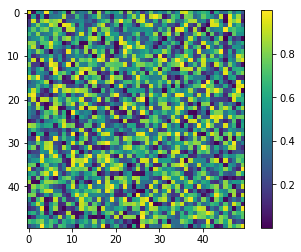

1 0.3667241742819115 12.598066146323735
2 0.3648363900133402 12.58010342802748
3 0.34060487895169195 12.47244120872444
4 0.2624308718373959 12.143951254947915
5 0.13606456625363156 16.57038527438491
6 0.172220863867105 14.487716214718217
7 0.25811304160591864 11.392755031493573
8 0.2833266722658231 11.787497499435426
9 0.28430009690052077 10.204758038604862
10 0.32769881688001196 8.679472095223918


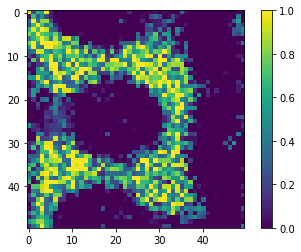

11 0.2692724451368469 13.929131367622936
12 0.313159191774652 9.524254352622007
13 0.34873302578562615 7.853242564641351
14 0.3595628281036957 7.59402809703758
15 0.3715852216905811 7.144749839929854
16 0.14754348553745542 14.174338432971968
17 0.3338016913104468 7.820846463267057
18 0.3748198308203319 7.018290717943912
19 0.37710218539367846 6.698106545116783
20 0.36104899824956177 6.655508486774906


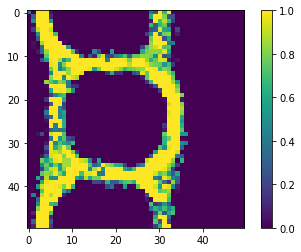

21 0.3730811808048561 6.6039334625582855
22 0.3707811136918367 6.501913313541945
23 0.37403790117265495 6.436811440500899
24 0.37116903011558955 6.386242378385047
25 0.3726060789327173 6.424939007254908
26 0.3734549884760896 6.3616284029264945
27 0.37089388026853753 6.338083475593946
28 0.3722828707635327 6.321783922355829
29 0.37052720739130723 6.286723915843372
30 0.37203414860611744 6.270710413138153


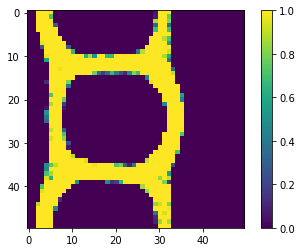

31 0.3570435939931347 6.504730490073075
32 0.37019311752874823 6.266710063427919
33 0.37143971451943225 6.253200824762253
34 0.37122684964101166 6.250271745825957
35 0.3703858398926028 6.243101245880273
36 0.3705714455244972 6.235421709115333
37 0.36832669147218594 6.234052415477003
38 0.3719427988957994 6.248430689547319
39 0.3699999886014847 6.231491555807705
40 0.3694801375398171 6.229098735702715


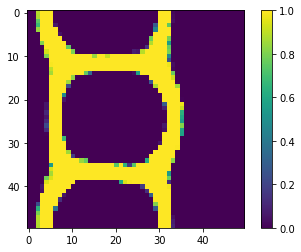

41 0.3704314851487242 6.226862081774699
42 0.36819679764532265 6.233150426700848
43 0.36927913085497893 6.227497460434352
44 0.36999407443537724 6.225834012202191
45 0.3701060482351009 6.225370576044561
46 0.3698180236488159 6.22457348446394
47 0.37055287931554914 6.2247589483165315
48 0.37024442937891944 6.224008993417134
49 0.3695359910756527 6.224586715535869
50 0.36998626340875024 6.223550867963679


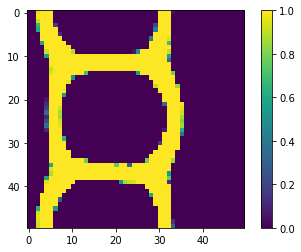

KeyboardInterrupt: 

In [28]:
Qabs = 20.
fun = lambda dof: fun_Distance(dof,Qabs)
grad_fun = grad(fun)
def fun_nlopt(dof,gradn):
    gradn[:] = grad_fun(dof)
    return fun(dof)

ndof = Nx*Ny
#init = np.ones(ndof)
init = np.random.random(ndof)
lb=np.zeros(ndof,dtype=float)
ub=np.ones(ndof,dtype=float)

opt = nlopt.opt(nlopt.LD_MMA, ndof)
opt.set_lower_bounds(lb)
opt.set_upper_bounds(ub)

opt.set_xtol_rel(1e-5)
opt.set_maxeval(100)

opt.set_min_objective(fun_nlopt)
x = opt.optimize(init)

# Qabs = 100

51 0.5663322066145566 4.183679979586967
52 0.5663329050985839 4.183644045490244
53 0.5663384992465856 4.1833021497186635
54 0.5663431662054047 4.180023792752007
55 0.56547080962963 4.179732448540173
56 0.5659672719183704 4.175564472248848
57 0.5659061114950397 4.174285291950841
58 0.5651121736412636 4.171564866628011
59 0.5627898046054038 4.174444272503293
60 0.5644129791410798 4.170291928458005


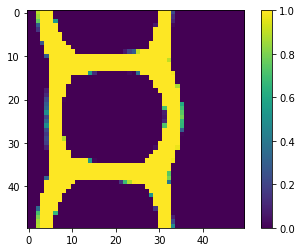

61 0.5638777060546796 4.170729225593013
62 0.564345468578824 4.169065596166035
63 0.5630700166901601 4.166282856829816
64 0.5615994026630514 4.165799972802819
65 0.5590649008219382 4.179044235937965
66 0.5611328859896803 4.162758787644376
67 0.5612849934914752 4.1619472634984875
68 0.5603284430213569 4.161145088723148
69 0.5604550314073687 4.161723243711244
70 0.5605036548028985 4.160274386796651


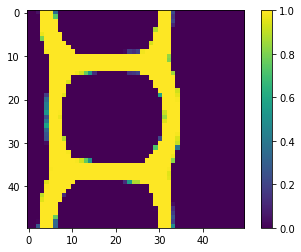

KeyboardInterrupt: 

In [29]:
Qabs = 100.
fun = lambda dof: fun_Distance(dof,Qabs)
grad_fun = grad(fun)
def fun_nlopt(dof,gradn):
    gradn[:] = grad_fun(dof)
    return fun(dof)

ndof = Nx*Ny
#init = np.ones(ndof)
init = npf.copy(vec)
lb=np.zeros(ndof,dtype=float)
ub=np.ones(ndof,dtype=float)

opt = nlopt.opt(nlopt.LD_MMA, ndof)
opt.set_lower_bounds(lb)
opt.set_upper_bounds(ub)

opt.set_xtol_rel(1e-5)
opt.set_maxeval(100)

opt.set_min_objective(fun_nlopt)
x = opt.optimize(init)

# Qabs = 1000

In [30]:
Qabs = 1000
fun = lambda dof: fun_Distance(dof,Qabs)
grad_fun = grad(fun)
def fun_nlopt(dof,gradn):
    gradn[:] = grad_fun(dof)
    return fun(dof)

ndof = Nx*Ny
#init = np.ones(ndof)
init = npf.copy(vec)
lb=np.zeros(ndof,dtype=float)
ub=np.ones(ndof,dtype=float)

opt = nlopt.opt(nlopt.LD_MMA, ndof)
opt.set_lower_bounds(lb)
opt.set_upper_bounds(ub)

opt.set_xtol_rel(1e-5)
opt.set_maxeval(100)

opt.set_min_objective(fun_nlopt)
x = opt.optimize(init)

71 0.6201553984449173 3.7896635843919357
72 0.6201546140088082 3.7896599260439574
73 0.6201471254466056 3.7896254592569925
74 0.6200403982165597 3.789252784807458
75 0.6191303501683951 3.788424396389628


KeyboardInterrupt: 

# Qabs = Inf

76 0.6261923250762252 3.7488819325029796
77 0.6261927963183074 3.748879722694341
78 0.6261974656002404 3.7488578945776134
79 0.6262571019361632 3.7485945236091704
80 0.6262739579281578 3.7480781408046937


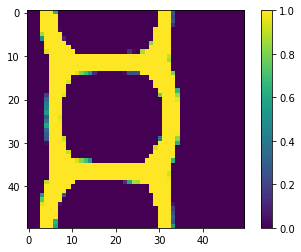

KeyboardInterrupt: 

In [31]:
Qabs = np.inf
fun = lambda dof: fun_Distance(dof,Qabs)
grad_fun = grad(fun)
def fun_nlopt(dof,gradn):
    gradn[:] = grad_fun(dof)
    return fun(dof)

ndof = Nx*Ny
#init = np.ones(ndof)
init = npf.copy(vec)
lb=np.zeros(ndof,dtype=float)
ub=np.ones(ndof,dtype=float)

opt = nlopt.opt(nlopt.LD_MMA, ndof)
opt.set_lower_bounds(lb)
opt.set_upper_bounds(ub)

opt.set_xtol_rel(1e-5)
opt.set_maxeval(100)

opt.set_min_objective(fun_nlopt)
x = opt.optimize(init)